# Advanced olfaction: Navigating a complex odor plume

**Author:** Victor Alfred Stimpfling

**Note:** The code presented in this notebook has been simplified and restructured for display in a notebook format. A more complete and better structured implementation can be found in the [examples folder of the FlyGym repository on GitHub](https://github.com/NeLy-EPFL/flygym/tree/main/flygym/examples/).

**Summary**: In this tutorial, we simulate a complex odor plume, replay the plume in MuJoCo, and build a simple controller to navigate it.


We have shown, in [a previous tutorial](https://neuromechfly.org/tutorials/olfaction.html), that our model is able to navigate a static odor gradient. In nature, static odor gradients are rather rare. On the contrary, dynamic plumes (c.f. illustration from [Demir et al, 2020](https://doi.org/10.7554/eLife.57524) below) with short intermittent bursts are more common. In such environments, odor gradients carry only limited information regarding the position of odor source. Consequently, navigating an odor plume requires multimodal integration of both wind and odor. In this notebook, we will demonstrate how one can create an odor plume using [PhiFlow](https://tum-pbs.github.io/PhiFlow/), a partial differential equations solver designed for machine learning that solves the Navier-Stokes equations to model the dynamics of a complex plume. We will also show how this plume dataset can be plugged into NeuroMechFly. Finally, we will design a very simple controller that can successfully navigate a complex plume based on the algorithm proposed in [Demir et al, 2020](https://doi.org/10.7554/eLife.57524).


<p align="center">
<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/plume_tracking/demir_et_al_real_odour_plume.jpg?raw=true" alt="complex plume" width="500"/>
<br>
<em>Image from <a href="https://doi.org/10.7554/eLife.57524">Demir et al, 2020</a>.</em>
</p>

## Simulating a complex odor plume

To demonstrate the flexibility of our framework, we will simulate an arbitrary odor plume resembling those in [Demir et al. 2020](https://doi.org/10.7554/eLife.57524). Our plume is modelled as a distinct substance embedded in an incompressible fluid. This is analogous to, for example, a food odor embedded in air. We simulate the plume by solving the Navier—Stokes equations in 2D. Our simulation is initialized with a constant velocity field, producing a right-bound "wind". In addition to the wind, we inject random perturbations as external forces exerted on the smoke. The force vector moves in Brownian motion, akin to random wind bursts driving turbulent flow.

Although we are simulating the plume in this tutorial, one can also replay an experimentally recorded plume dataset.

To generate your own plume, make sure you have installed PhiFlow. This should have been done already if you installed the "examples" optional dependency of flygym (`pip install "flygym[examples]"`).

Let's decide on a few hyperparameters defining our plume:

- The size of the arena
- A scaling factor (i.e., spatial resolution) for the velocity and smoke grids
- The position and size of the inflow

In [1]:
# This notebook is partially based on the following script by  Felix Köhler:
# https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/phiflow/smoke_plume.py

import numpy as np
import h5py
from phi.torch import flow
from typing import Tuple
from tqdm import trange
from pathlib import Path

np.random.seed(0)
# change the simulation time to have a shorter simulation
simulation_time = 20.0
dt = 0.05
arena_size = (80, 60)
inflow_pos = (4, 30)
inflow_radius = 1
inflow_scaler = 0.2
velocity_grid_size = 0.5
smoke_grid_size = 0.25
simulation_steps = int(simulation_time / dt)

Next we define the dynamics of the plume in more detail. In particular, we load a helper function that outputs the Brownian contribution to the total wind at every time step.

```Python
def converging_brownian_step(
    value_curr: np.ndarray,
    center: np.ndarray,
    gaussian_scale: float = 1.0,
    convergence: float = 0.5,
) -> np.ndarray:
    """Step to simulate Brownian noise with convergence towards a center.

    Parameters
    ----------
    value_curr : np.ndarray
        Current value of variables (i.e., noise) in Brownian motion.
    center : np.ndarray
        Center towards which the Brownian motion converges.
    gaussian_scale : float, optional
        Standard deviation of Gaussian noise to be added to the current
        value, by default 1.0
    convergence : float, optional
        Factor of convergence towards the center, by default 0.5.

    Returns
    -------
    np.ndarray
        Next value of variables (i.e., noise) in Brownian motion.
    """
    gaussian_center = (center - value_curr) * convergence
    value_diff = np.random.normal(
        loc=gaussian_center, scale=gaussian_scale, size=value_curr.shape
    )
    value_next = value_curr + value_diff
    return value_next
```

In [2]:
from flygym.examples.olfaction.simulate_plume_dataset import converging_brownian_step

# Simulate Brownian noise and store the wind for every time step
curr_wind = np.zeros((2,))
wind_hist = [curr_wind.copy()]
for i in range(simulation_steps):
    curr_wind = converging_brownian_step(curr_wind, (0, 0), (1.2, 1.2), 1.0)
    wind_hist.append(curr_wind.copy())

# Define simulation grids
# constant velocity vector in every points
velocity = flow.StaggeredGrid(
    values=(10.0, 0.0),  # constant velocity field to the right
    extrapolation=flow.extrapolation.BOUNDARY,
    x=int(arena_size[0] / velocity_grid_size),
    y=int(arena_size[1] / velocity_grid_size),
    bounds=flow.Box(x=arena_size[0], y=arena_size[1]),
)

# choose extrapolation mode from
# ('undefined', 'zeros', 'boundary', 'periodic', 'symmetric', 'reflect')
# Zero smoke field at the beginning of the simulation
smoke = flow.CenteredGrid(
    values=0.0,
    extrapolation=flow.extrapolation.BOUNDARY,
    x=int(arena_size[0] / smoke_grid_size),
    y=int(arena_size[1] / smoke_grid_size),
    bounds=flow.Box(x=arena_size[0], y=arena_size[1]),
)

# Define inflow
inflow = inflow_scaler * flow.field.resample(
    flow.Sphere(x=inflow_pos[0], y=inflow_pos[1], radius=inflow_radius),
    to=smoke,
    soft=True,
)

Let's visualize the velocity field, the smoke density, and the inflow at the beginning of the simulation:

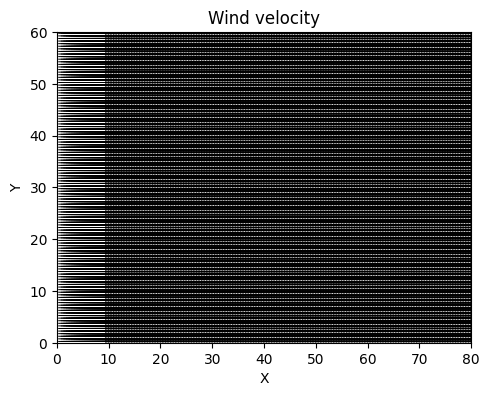

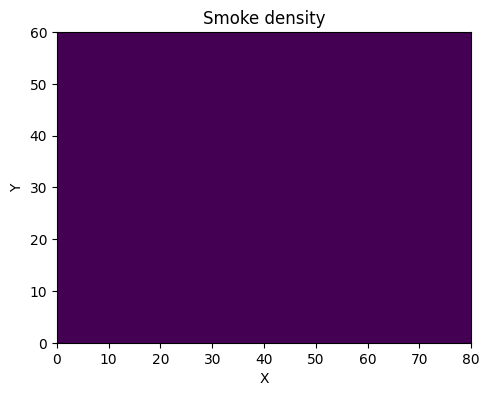

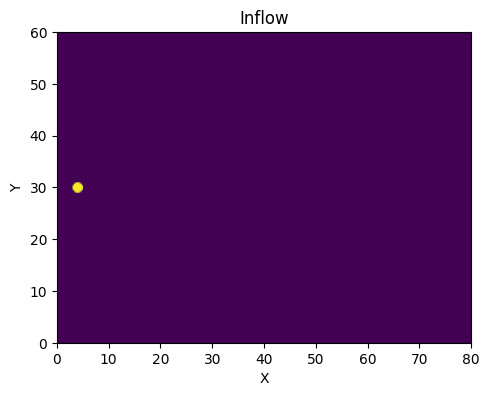

In [3]:
from matplotlib import pyplot as plt
from phi import vis
from pathlib import Path

output_dir = Path("outputs/plume_tracking")
output_dir.mkdir(parents=True, exist_ok=True)

fig = vis.plot(velocity, title="Wind velocity", size=(5, 4))
plt.gcf().savefig(output_dir / "wind_velocity_t0.png")

fig = vis.plot(smoke, title="Smoke density", size=(5, 4), show_color_bar=False)
plt.gcf().savefig(output_dir / "smoke_density_t0.png")

fig = vis.plot(inflow, title="Inflow", size=(5, 4), show_color_bar=False)
plt.gcf().savefig(output_dir / "inflow_t0.png")

Now we are ready to simulate the plume. For that we use the following step function:

```Python
def step(
    velocity_prev: flow.Grid,
    smoke_prev: flow.Grid,
    noise: np.ndarray,
    noise_magnitude: Tuple[float, float] = (0.1, 2),
    dt: float = 1.0,
    inflow: flow.Grid = None,
    ) -> Tuple[flow.Grid, flow.Grid]:
    """Simulate fluid dynamics by one time step.

    Parameters
    ----------
    velocity_prev : flow.Grid
        Velocity field at previous time step.
    smoke_prev : flow.Grid
        Smoke density at previous time step.
    noise : np.ndarray
        Brownian noise to be applied as external force.
    noise_magnitude : Tuple[float, float], optional
        Magnitude of noise to be applied as external force in x and y
        directions, by default (0.1, 2)
    dt : float, optional
        Simulation time step, by default 1.0

    Returns
    -------
    Tuple[flow.Grid, flow.Grid]
        Velocity field and smoke density at next time step.
    """
    smoke_next = flow.advect.mac_cormack(smoke_prev, velocity_prev, dt=dt) + inflow
    external_force = smoke_next * noise * noise_magnitude @ velocity_prev
    velocity_tentative = (
        flow.advect.semi_lagrangian(velocity_prev, velocity_prev, dt=dt)
        + external_force
    )
    velocity_next, pressure = flow.fluid.make_incompressible(velocity_tentative)
    return velocity_next, smoke_next
```

For every time step, we let the smoke advect in the velocity field and add new smoke through the inflow. Then the velocity field (composed of the previous wind and Brownian external noise) is self advected to get the next velocity field and finally the pressures are projected using the make incompressible function. 
The step function will be repeated to unroll the full plume.

In [4]:
from flygym.examples.olfaction.simulate_plume_dataset import step

# Run fluid dynamics simulation
smoke_hist = []
for i in trange(simulation_steps):
    velocity, smoke = step(
        velocity,
        smoke,
        wind_hist[i],
        dt=dt,
        inflow=inflow,
        noise_magnitude=(0.5, 100.0),
    )
    smoke_vals = smoke.values.numpy("y,x")
    smoke_hist.append(smoke_vals)

  0%|          | 0/400 [00:00<?, ?it/s]/opt/anaconda3/envs/flygym/lib/python3.12/site-packages/phi/torch/_torch_backend.py:662: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(row_pointers, column_indices, values, shape, device=values.device)
/opt/anaconda3/envs/flygym/lib/python3.12/site-packages/phi/torch/_torch_backend.py:524: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return tuple([int(s) for s in tensor.shape])
/opt/anaconda3/envs/flygym/lib/python3.12/site-packages/phi/torch/_

Because our time steps are much larger than that of the NeuroMechFly physics simulation, we interpolate the smoke field. This is much faster than running the plume simulation with smaller time steps:

In [5]:
from scipy.interpolate import interp1d

sim_timepoints = np.arange(0, simulation_time, step=dt)
smoke_hist_interp_fun = interp1d(sim_timepoints, smoke_hist, axis=0)

new_timepoints = np.linspace(0, simulation_time - dt, num=10000)
smoke_hist_interp = smoke_hist_interp_fun(new_timepoints)

We will visualize the velocity field, the smoke density, and the inflow at the end of the simulation:

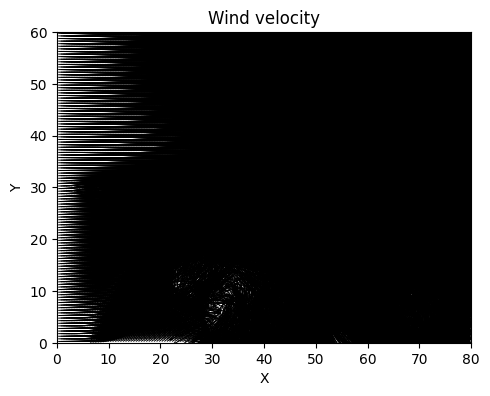

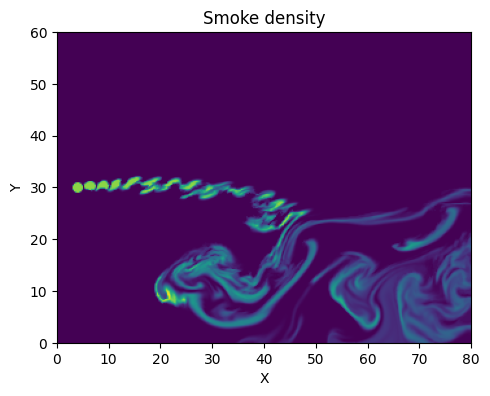

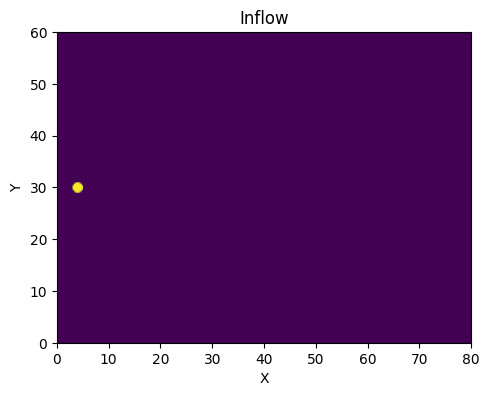

In [6]:
fig = vis.plot(velocity, title="Wind velocity", size=(5, 4))
plt.gcf().savefig(output_dir / "wind_velocity_tf.png")

fig = vis.plot(smoke, title="Smoke density", size=(5, 4), show_color_bar=False)
plt.gcf().savefig(output_dir / "smoke_density_tf.png")

fig = vis.plot(inflow, title="Inflow", size=(5, 4), show_color_bar=False)
plt.gcf().savefig(output_dir / "inflow_tf.png")

Let's save this plume dataset in the HDF5 format. HDF5 is an efficient data format for saving arrays. Different from NumPy's built-in formats (NPY or NPZ), HDF5 allows partial reads of the dataset. In other words, with NPZ:

```Python
array = np.load("/path/to/file.npz")  # this reads the whole array from disk to RAM

for idx in my_iterator:
    part = array[idx, :]  # further slicing of data simply takes portions of the array from RAM
```

... but with HDF5:

```Python
h5file = h5py.File("/path/to/file.hdf5")  # this only loads the metadata; data stays on disk
dataset = h5file["key"]  # HDF5 datasets are NumPy-array-like and can be accessed the same way

for idx in my_iterator:
    part = dataset[idx, :]  # only now is the *specified portion* of data loaded into RAM
```

Therefore, at a slight cost of data loading overhead, we massively reduce the RAM usage of our program (only the plume state at the current time step is loaded into memory; the rest of the dataset remains on the hard disk). Although this does not make a practical difference in this tutorial, it become important if we want to run multiple long simulations in parallel. More information about the HDF5 data format can be found [here](https://docs.h5py.org/en/stable/quick.html).

In [7]:
with h5py.File(output_dir / "plume.hdf5", "w") as f:
    f["plume"] = np.stack(smoke_hist_interp).astype(np.float16)
    f["inflow_pos"] = inflow_pos
    f["inflow_radius"] = [inflow_radius]  # save as array with a single value
    f["inflow_scaler"] = [inflow_scaler]  # "

## Creating a plume within an arena

The next step is to create an environment in which the fly can navigate the plume. For the sake of simplicity, here the pre-recorded plume is simply replayed and does not physically interact with the fly.

The `OdorPlumeArena` class implements all the necessary functions to obtain sensory input from the plume and resample the plume to the size of the arena.
In our plume simulation, the smoke grid has a spatial resolution of $\Delta x_\text{smoke} = 0.25$ units in an arena of size $(X_\text{max}, Y_\text{max})$ units. We allow the user to define how this grid is scaled to the physical arena using a dimensional scale parameter $s$: the size of the arena that the fly walks in is given by $s(X_\text{max}, Y_\text{max}) / \Delta x_\text{smoke}$ mm. For example, at $s=0.5$, the size of the arena is $0.5 \times (80, 60) / 0.25 = (160, 120)$ mm. Similarly, the user can specify the speed at which the plume simulation is played out by setting the FPS of the plume dataset. These parameters are managed as follows:

``` Python 
class OdorPlumeArena(BaseArena):
    """
    This Arena class provides an interface to the separately simulated
    odor plume. The plume simulation is stored in an HDF5 file. In this
    class, we implement logics that calculate the intensity of the odor
    at the fly's location at the correct time.
    """
    def __init__(
            self,
            plume_data_path: Path,
            main_camera_name: str,
            dimension_scale_factor: float = 0.5,
            plume_simulation_fps: float = 200,
            intensity_scale_factor: float = 1.0,
            friction: Tuple[float, float, float] = (1, 0.005, 0.0001),
            num_sensors: int = 4,
        ):
            """
            Parameters
            ----------
            plume_data_path : Path
                Path to the HDF5 file containing the plume simulation data.
            main_camera_name : str
                Name of the main camera used to render the plume simulation.
            dimension_scale_factor : float, optional
                Scaling factor for the plume simulation grid. Each cell in the
                plume grid is this many millimeters in the simulation. By
                default 0.5.
            plume_simulation_fps : float, optional
                Frame rate of the plume simulation. Each frame in the plume
                dataset is ``1 / plume_simulation_fps`` seconds in the physics
                simulation. By default 200.
            intensity_scale_factor : float, optional
                Scaling factor for the intensity of the odor. By default 1.0.
            friction : Tuple[float, float, float], optional
                Friction parameters for the floor geom. By default (1, 0.005,
                0.0001).
            num_sensors : int, optional
                Number of olfactory sensors on the fly. By default 4.
            """

            super().__init__()

            self.dimension_scale_factor = dimension_scale_factor
            self.plume_simulation_fps = plume_simulation_fps
            self.intensity_scale_factor = intensity_scale_factor
            self.friction = friction
            self.num_sensors = num_sensors
            self.curr_time = 0
            self.plume_update_interval = 1 / plume_simulation_fps

            # Load plume data
            self.plume_dataset = h5py.File(plume_data_path, "r")
            self.plume_grid = self.plume_dataset["plume"]
            self.arena_size = (
                np.array(self.plume_grid.shape[1:][::-1]) * dimension_scale_factor
            )

            # Set up floor
            floor_material = self.root_element.asset.add(
                "material",
                name="floor_material",
                reflectance=0.0,
                shininess=0.0,
                specular=0.0,
                rgba=[0.6, 0.6, 0.6, 1],
            )
            self.root_element.worldbody.add(
                "geom",
                name="floor",
                type="box",
                size=(self.arena_size[0] / 2, self.arena_size[1], 1),
                pos=(self.arena_size[0] / 2, self.arena_size[1] / 2, -1),
                material=floor_material,
            )
```

We will also implement a function that reads out the odor intensity for every sensor from the simulated smoke grid:

```Python 
def get_olfaction(self, antennae_pos: np.ndarray) -> np.ndarray:
        """
        Returns the olfactory input for the given antennae positions. If
        the fly is outside the plume simulation grid, returns np.nan.
        """
        # get the current frame of the plume
        frame_num = int(self.curr_time * self.plume_simulation_fps)
        assert self.num_sensors == antennae_pos.shape[0]
        intensities = np.zeros((self.odor_dimensions, self.num_sensors))
        for i_sensor in range(self.num_sensors):
            # get the sensor position in mm (from the physics)
            x_mm, y_mm, _ = antennae_pos[i_sensor, :]
            # map to our simulated plume dimensions
            x_idx = int(x_mm / self.dimension_scale_factor)
            y_idx = int(y_mm / self.dimension_scale_factor)
            if (
                x_idx < 0
                or y_idx < 0
                or x_idx >= self.plume_grid.shape[2]
                or y_idx >= self.plume_grid.shape[1]
            ):
                intensities[0, i_sensor] = np.nan
            else:
                intensities[0, i_sensor] = self.plume_grid[frame_num, y_idx, x_idx]
        return intensities * self.intensity_scale_factor
```

Finally, we will implement a function to get the position mapping between the main_camera and indices in the simulated plume grid. This will become very handy when we want to project the simulated plume onto the arena for proper rendering.
 
``` Python
def get_position_mapping(
        self, sim: Simulation
    ) -> np.ndarray:
        """Get the display location (row-col coordinates) of each pixel in
        the fluid dynamics simulation.

        Parameters
        ----------
        sim : Simulation
            Simulation simulation object.
        Returns
        -------
        pos_display: np.ndarray
            Array of shape (n_row_pxls_plume, n_col_pxls_plume, 2)
            containing the row-col coordinates of each plume simulation
            cell on the **display** image (in pixels).
        pos_physical: np.ndarray
            Array of shape (n_row_pxls_plume, n_col_pxls_plume, 2)
            containing the row-col coordinates of each plume simulation
            cell on the **physical** simulated grid (in mm). This is a
            regular lattice grid marking the physical position of the
            *centers* of the fluid simulation cells.
        """
        birdeye_cam_dm_control_obj = Camera(
            sim.physics,
            camera_id=self.main_camera_name,
            width=sim.cameras[0].window_size[0],
            height=sim.cameras[0].window_size[1],
        )
        camera_matrix = birdeye_cam_dm_control_obj.matrix
        # Get the center of every grid cell
        xs_physical, ys_physical = np.meshgrid(
            np.arange(self.arena_size[0]) + 0.5,
            np.arange(self.arena_size[1]) + 0.5,
        )
        # project those centers to the camera coordinates
        xyz1_vecs = np.ones((xs_physical.size, 4))
        xyz1_vecs[:, 0] = xs_physical.flatten()
        xyz1_vecs[:, 1] = ys_physical.flatten()
        xyz1_vecs[:, 2] = 0
        pos_physical = xyz1_vecs[:, :2].reshape(*xs_physical.shape, 2)
        xs_display, ys_display, display_scale = camera_matrix @ xyz1_vecs.T
        xs_display /= display_scale
        ys_display /= display_scale
        pos_display = np.vstack((xs_display, ys_display))
        pos_display = pos_display.T.reshape(*xs_physical.shape, 2)
        return pos_display, pos_physical

```

We will create an `OdorPlumeArena` instance. For the sake of demonstration, we will use a dimensional scale factor of 0.25 and a very high plume FPS to make the simulation easier to run.

In [8]:
from flygym.examples.olfaction.plume_tracking_arena import OdorPlumeArena

main_camera_name = "birdeye_camera"
arena = OdorPlumeArena(
    output_dir / "plume.hdf5", main_camera_name=main_camera_name,
    plume_simulation_fps=8000, dimension_scale_factor=0.25
)

Now, we are ready to implement the main simulation loop. We will make the fly stand still for the sake of this demonstration:

In [9]:
from flygym import Fly, SingleFlySimulation, Camera
from flygym.examples.locomotion import PreprogrammedSteps

timestep = 1e-4
run_time = 1.0

# Initialize fly simulation
fly = Fly(
    enable_olfaction=True,
    spawn_pos=(60.0, 30.0, 0.25),
    spawn_orientation=(0, 0, -np.pi / 2),
)
cam_params = {"mode":"fixed",
    "pos": (
                0.50 * arena.arena_size[0],
                0.15 * arena.arena_size[1],
                1.00 * arena.arena_size[1],
            ),
    "euler":(np.deg2rad(15), 0, 0), "fovy":60}
    
cam = Camera(
    attachment_point=arena.root_element.worldbody,
    camera_name=main_camera_name,
    timestamp_text = False,
    camera_parameters=cam_params
)
sim = SingleFlySimulation(fly=fly, arena=arena, cameras=[cam])

preprogrammed_step = PreprogrammedSteps()
standing_joint_angles = []

for leg in preprogrammed_step.legs:
    standing_joint_angles.extend(preprogrammed_step.get_joint_angles(leg, 0.0))

target_num_steps = int(run_time / timestep)
obs_list = []

for i in trange(target_num_steps):
    (obs, reward, terminated, truncated, info) = sim.step(
        action={"joints": standing_joint_angles}
    )
    obs_list.append(obs)
    sim.render()

100%|██████████| 10000/10000 [00:21<00:00, 461.10it/s]


Let's plot the time series of the odor intensities sensed by the fly's olfactory sensory organs:

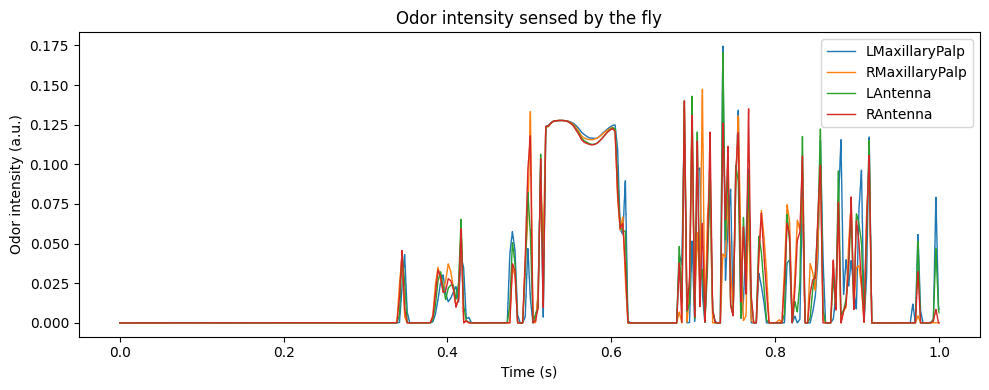

In [10]:
odor_intensities = np.array([obs["odor_intensity"] for obs in obs_list])
time = np.arange(0, run_time, timestep)

fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)

lines = ax.plot(time, odor_intensities.squeeze(), lw=1)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Odor intensity (a.u.)")
ax.set_title("Odor intensity sensed by the fly")

ax.legend(lines, [sensor.name.split("_")[0] for sensor in fly._antennae_sensors])
fig.savefig(output_dir / "odor_intensity_ts.png")

We can also generate a video of the simulation:

In [11]:
cam.save_video(output_dir / "sim_static.mp4")

But we don't see the plume here! This is because we are simply reading out the appropriate values from the pre-generated plume dataset. The odor is not actually added or visualized in any way in the NeuroMechFly physics simulation. In the next section, we will build another layer of abstraction that overlays the image of the plume onto the rendered image for visualization.

## Plume tracking task

By now, we have implemented an odor plume arena that replays the simulated plume. The fly can walk in this arena and experience intermittent bursts of odor. We will now implement a wrapper for the plume tracking task. In this layer of abstraction, we will implement the following functionalities:

1. Overlay the plume on top of the rendered image.
2. Truncate the simulation when the fly walks out of bound.

Recall [the construction of the Markov Decision Process (MDP)](https://neuromechfly.org/tutorials/gym_basics_and_kinematic_replay.html#markov-decision-process-mdp-and-the-gym-api). The task that we are implementing is the Task/Environment under the MPD framework. Therefore, it is an `Env` in the Gymnasium interface. We will extend the `HybridTurningController` environment for this purpose.

We start with the `__init__` method. Here, we use the `get_position_mapping` function that we have implemented for `OdorPlumeArena` to find the following for each element in the odor simulation grid:

1. The row-column position of it on the image rendered by the camera.
2. The x-y position, in mm, of the physical spot where the center of cell is on the smoke grid.

Then, we will interpolate these points in 2D so that for every pixel displayed on the camera's output, we know which cell it corresponds to on the plume grid and what the x-y coordinates are in the physical arena.

```Python
class PlumeNavigationTask(HybridTurningController):
    """
    A wrapper around the ``HybridTurningController`` that implements logics
    and utilities related to plume tracking such as overlaying the plume
    onto the rendered images. It also checks if the fly is within the plume
    simulation grid and truncates the simulation accordingly.
    """

    def __init__(
        self,
        fly: Fly,
        arena: OdorPlumeArena,
        render_plume_alpha: float = 0.75,
        intensity_display_vmax: float = 1.0,
        **kwargs,
    ):
        """
        Parameters
        ----------
        fly: Fly
            The fly object to be used. See
            ``flygym.example.locomotion.HybridTurningController``.
        arena: OdorPlumeArena
            The odor plume arena object to be used. Initialize it before
            creating the ``PlumeNavigationTask`` object.
        render_plume_alpha : float
            The transparency of the plume overlay on the rendered images.
        intensity_display_vmax : float
            The maximum intensity value to be displayed on the rendered
            images.
        """
        super().__init__(fly=fly, arena=arena, **kwargs)
        self.arena = arena
        self._plume_last_update_time = -np.inf
        self._cached_plume_img = None
        self._render_plume_alpha = render_plume_alpha
        self._intensity_display_vmax = intensity_display_vmax

        # Find out where on the displayed images the plume simulation grid
        # should be overlaid. In other words, interpolate the mapping from
        # displayed pixel positions to simulated physical positions.
        pos_display_sample, pos_physical_sample = self.arena.get_position_mapping(self)
        pos_display_sample = pos_display_sample.reshape(-1, 2)
        pos_physical_sample = pos_physical_sample.reshape(-1, 2)
        interp = LinearNDInterpolator(
            pos_display_sample, pos_physical_sample, fill_value=np.nan
        )
        xs_display, ys_display = np.meshgrid(
            np.arange(self.cameras[0].window_size[0]),
            np.arange(self.cameras[0].window_size[1]),
        )
        pos_display_all = np.vstack([xs_display.flatten(), ys_display.flatten()]).T
        pos_physical_all = interp(pos_display_all)
        pos_physical_all = pos_physical_all.reshape(
            *self.cameras[0].window_size[::-1], 2
        )
        grid_idx_all = pos_physical_all / self.arena.dimension_scale_factor
        grid_idx_all[np.isnan(grid_idx_all)] = -1
        # self.grid_idx_all has the shape (cam_nrows, cam_ncols, 2) and
        # indicates the (x, y) indices of the plume simulation grid cell.
        # When the index is -1, this point on the displayed image is out of
        # the simulated arena.
        self.grid_idx_all = grid_idx_all.astype(np.int16)

        self.focus_cam = self.cameras[1] if len(self.cameras) > 1 else None
        if self.focus_cam is not None:
            self.fc_width, self.fc_height = self.focus_cam.window_size
            pixel_meshgrid = np.meshgrid(
                np.arange(self.fc_width), np.arange(self.fc_height)
            )
            self.pixel_idxs = np.stack(
                [pixel_meshgrid[0].flatten(), pixel_meshgrid[1].flatten()], axis=1
            )
```

To override the `render` method, we just need to get the plume image corresponding to the current time point and overlay it on top of the camera image. We also add a bar indicating the mean intensity to the bottom image for better visualization.

```Python
def render(self, *args, **kwargs):
    rendered_img = super().render(*args, **kwargs)[0]
    if rendered_img is None:
        return [rendered_img]  # no image rendered

    # Overlay plume
    time_since_last_update = self.curr_time - self._plume_last_update_time
    update_needed = time_since_last_update > self.arena.plume_update_interval
    if update_needed or self._cached_plume_img is None:
        t_idx = int(self.curr_time * self.arena.plume_simulation_fps)
        self._cached_plume_img = _resample_plume_image(
            self.grid_idx_all, self.arena.plume_grid[t_idx, :, :].astype(np.float32)
        )
        self._plume_last_update_time = self.curr_time
    plume_img = self._cached_plume_img[:, :, np.newaxis] * self._render_plume_alpha
    plume_img[np.isnan(plume_img)] = 0
    rendered_img = np.clip(rendered_img - plume_img * 255, 0, 255).astype(np.uint8)

    # Add intensity indicator
    mean_intensity = self.get_observation()["odor_intensity"].mean()
    mean_intensity_relative = np.clip(
        mean_intensity / self._intensity_display_vmax, 0, 1
    )
    rmin = self.cameras[0].window_size[1] - 10
    rmax = self.cameras[0].window_size[1]
    cmin = 0
    cmax = int(self.cameras[0].window_size[0] * mean_intensity_relative)
    rendered_img[rmin:rmax, cmin:cmax] = (255, 0, 0)

    # Replace recorded image with modified one
    self.cameras[0]._frames[-1] = rendered_img
    return [rendered_img]
```

Let's just define a fly, an arena and a camera to start with.

The actual `_resample_plume_image` function is accelerated with [Numba](https://numba.pydata.org/). This is because we need to iterate every pixel to modify its value, and loops in native, uncompiled Python [are extremely slow](https://stackoverflow.com/questions/8097408/why-python-is-so-slow-for-a-simple-for-loop). With Numba's `njit` [decorator](https://peps.python.org/pep-0318/), we can compile the Python code into LLVM — a low-level code that directly interfaces with the CPU through backends — just in time (hence the "JIT" in `njit`). Furthermore, we will force Numba to do this in a "no-Python" way (hence the "N" in `njit`) to ensure fast execution. These changes give us C-like performance in the render function.

``` Python 
from numba import njit

@njit(parallel=True)
def _resample_plume_image(grid_idx_all, plume_grid):
    plume_img = np.zeros(grid_idx_all.shape[:2])
    for i in prange(grid_idx_all.shape[0]):
        for j in prange(grid_idx_all.shape[1]):
            x_idx = grid_idx_all[i, j, 0]
            y_idx = grid_idx_all[i, j, 1]
            if x_idx != -1:
                plume_img[i, j] = plume_grid[y_idx, x_idx]
    return plume_img

```

To truncate the simulation when the fly moves out of bounds, we can simply set the `truncate` flag — returned by the `step` method of any Gymnasium environment — to `True`. Recall that we have already implemented a logic in the `OdorPlumeArena` that returns NaN when the queried position is out of bounds. Therefore,

```Python
    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        if np.isnan(obs["odor_intensity"]).any():
            truncated = True
        return obs, reward, terminated, truncated, info
```

Let's run a sample simulation where the fly walks blindly forward:

In [13]:
from flygym.examples.olfaction.plume_tracking_task import PlumeNavigationTask

arena = OdorPlumeArena(
    output_dir / "plume.hdf5", main_camera_name=main_camera_name,
    plume_simulation_fps=8000, dimension_scale_factor=0.25
)

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

fly = Fly(
    enable_adhesion=True,
    draw_adhesion=True,
    enable_olfaction=True,
    enable_vision=False,
    contact_sensor_placements=contact_sensor_placements,
    spawn_pos=(60.0, 30.0, 0.25),
    spawn_orientation=(0, 0, -np.pi / 2),
)
cam_params = {"mode":"fixed",
    "pos": (
                0.50 * arena.arena_size[0],
                0.15 * arena.arena_size[1],
                1.00 * arena.arena_size[1],
            ),
    "euler":(np.deg2rad(15), 0, 0), "fovy":60}
    
cam = Camera(
    attachment_point=arena.root_element.worldbody,
    camera_name=main_camera_name,
    timestamp_text = False,
    camera_parameters=cam_params
)

sim = PlumeNavigationTask(
    fly=fly,
    arena=arena,
    cameras=[cam],
)

sim.reset(0)

straight_dn_drive = np.array([1.0, 1.0])
for i in trange(target_num_steps):
    obs, reward, terminated, truncated, info = sim.step(straight_dn_drive)
    sim.render()

cam.save_video(output_dir / "plume_display.mp4")

100%|██████████| 10000/10000 [00:33<00:00, 299.27it/s]


## Implementing a plume tracking controller

Having implemented the MDP task for plume tracking, we are finally ready to build a plume following controller. We propose a model where the fly walks crosswind when little odor evidence is accumulated and upwind when encountering a lot of odor packets. The crosswind direction is random and biased by the encounter history during crosswind walks.

It takes time for the first plume burst to reach the fly. We will crop the first half of the plume simulation so that the plume reaches the fly immediately. This is merely to shorten the simulation in this tutorial and is optional.

In [14]:
time_cropped_plume = smoke_hist_interp[1000:]

# lets crop a few frames from the plume simulation
with h5py.File(output_dir / "plume_tcropped.hdf5", "w") as f:
    f["plume"] = np.stack(time_cropped_plume).astype(np.float16)
    f["inflow_pos"] = inflow_pos
    f["inflow_radius"] = inflow_radius
    f["inflow_scaler"] = inflow_scaler

We implement the plume navigation controller as follows. Our controller accumulates odor evidence during a fixed interval of time. The accumulated evidence increases with odor encounters and decreases with time. From accumulated evidence, we derive the angle of wind direction. The more evidence accumulated, the more likely it is that the fly will head upwind. It heads more randomly, i.e., more crosswind, when no evidence is accumulated. When the target angle is defined, the descending drive is regularly updated to match the target angle. See [Demir et al, 2020](https://doi.org/10.7554/eLife.57524) or our NeuroMechFly v2 paper for more details.

In [15]:
from enum import Enum
import cv2
from flygym.util import get_data_path


class WalkingState(Enum):
    FORWARD = 0
    TURN_LEFT = 1
    TURN_RIGHT = 2
    STOP = 3


# get the angle of the vector in world coordinates
def get_vector_angle(v):
    return np.arctan2(v[1], v[0])


# change an array to a set of probabilities (sum to 1)
# this is used to bias crosswind walking
def to_probability(x):
    # the difference between the two values reflects
    # the probability of each entry
    x += np.abs(np.min(x)) + 1
    return x / np.sum(x)


class SimplePlumeNavigationController:
    # defines a very simple controller to navigate the odor plume
    def __init__(self, timestep, wind_dir=[-1.0, 0.0], seed=0):
        self.timestep = timestep
        self.wind_dir = wind_dir

        np.random.seed(seed)

        # define the dn drives for each state
        self.dn_drives = {
            WalkingState.FORWARD: np.array([1.0, 1.0]),
            WalkingState.TURN_LEFT: np.array((-0.4, 1.2)),
            WalkingState.TURN_RIGHT: np.array((1.2, -0.4)),
            WalkingState.STOP: np.array((0.0, 0.0)),
        }

        # evidence acccumulation parameters
        self.accumulated_evidence = 0.0
        self.accumulation_decay = 0.0001
        self.accumulation_odor_gain = 0.05
        self.accumulation_threshold = 20.0

        # decision making parameters
        self.default_decision_interval = 0.75  # s
        self.since_last_decision_time = 0.0

        # minimal evidence value during a decision interval
        self.min_evidence = (
            -1 * self.accumulation_decay * self.default_decision_interval / timestep
        )

        # descending neuron drive parameters
        self.dn_drive_update_interval = 0.1  # s
        self.dn_drive_update_steps = int(self.dn_drive_update_interval / self.timestep)
        self.dn_drive = self.dn_drives[WalkingState.STOP]

        # controller state parameters
        self.curr_state = WalkingState.STOP
        self.target_angle = np.nan
        self.to_upwind_angle = np.nan
        self.upwind_success = [0, 0]

        # boundary checking parameters
        self.boundary_refractory_period = 1.0
        self.boundary_time = 0.0

    def get_target_angle(self):
        """
        Get the target angle to the wind based on the accumulated evidence, the wind direction
        and the history of success in the crosswind direction
        The target angle is more upwind if the accumulated evidence is high
        and more crosswind if the accumulated evidence is low

        Returns
        -------
        target_angle : float
            The target angle to the wind (in radian)
        to_upwind_angle : float
            The angle to the upwind direction (in radian)
        """

        up_wind_angle = get_vector_angle(self.wind_dir) - np.pi
        # the angle to the wind is defined by the accumulated evidence:
        #   - if little evidence, the fly will go crosswind (angle to upwind = np.pi/2)
        #   - if a lots of evidence, the fly will go upwind (angle to upwind = 0)
        to_upwind_angle = np.tanh(self.accumulated_evidence) * np.pi / 4 - np.pi / 4
        crosswind_success_proba = to_probability(self.upwind_success)

        # randomize the sign of the angle depending on the history of success
        to_upwind_angle = np.random.choice([-1, 1], p=crosswind_success_proba) * np.abs(
            to_upwind_angle
        )

        # compute the target angle (the up wind angle + the angle to upwind direction)
        target_angle = up_wind_angle + to_upwind_angle
        if target_angle > np.pi:
            target_angle -= 2 * np.pi
        elif target_angle < -np.pi:
            target_angle += 2 * np.pi

        return target_angle, to_upwind_angle

    def angle_to_dn_drive(self, fly_orientation):
        """
        Compare the fly's orientation to the target angle and return the
        descending drive that will make the fly go in the correct direction

        Parameters
        ----------
        fly_orientation : np.array
            The fly orientation vector

        Returns
        -------
        dn_drive : np.array
            The dn drive that will make the fly go in the correct direction
        """

        fly_angle = get_vector_angle(fly_orientation)
        angle_diff = self.target_angle - fly_angle
        if angle_diff > np.pi:
            angle_diff -= 2 * np.pi
        elif angle_diff < -np.pi:
            angle_diff += 2 * np.pi

        if np.isnan(self.target_angle):
            return self.dn_drives[WalkingState.STOP], WalkingState.STOP
        elif angle_diff > np.deg2rad(10):
            return self.dn_drives[WalkingState.TURN_LEFT], WalkingState.TURN_LEFT
        elif angle_diff < -np.deg2rad(10):
            return self.dn_drives[WalkingState.TURN_RIGHT], WalkingState.TURN_RIGHT
        else:
            return self.dn_drives[WalkingState.FORWARD], WalkingState.FORWARD

    def step(self, fly_orientation, odor_intensities, close_to_boundary, curr_time):
        """
        Step the controller:
          - Check if the fly is close to the boundary
          - Accumulate evidence
          - Update the target angle if:
            - the accumulated evidence is high
            - the decision interval is reached
            - the fly is close to the boundary
          - Update the success history:
            - If crosswind: update the success history (increases if
              the fly collected evidence in that direction, decreases otherwise)
            - If close to boundary and the fly is not upwind: decrease success history
          - Update the descending drive
          - Increment time and counters

        Parameters
        ----------
        fly_orientation : np.array
            The fly orientation vector
        odor_intensities : np.array
            The odor intensities collected by the fly
        close_to_boundary : bool
            Whether the fly is close to the boundary
        curr_time : float
            The current time of the simulation

        Returns
        -------
        dn_drive : np.array
            The dn drive that will make the fly go in the correct direction
        """

        if self.boundary_time > 0.0:
            self.boundary_time += self.timestep
        elif self.boundary_time > self.boundary_refractory_period:
            self.boundary_time = 0.0

        boundary_inv = close_to_boundary and self.boundary_time == 0.0

        if (
            self.accumulated_evidence > self.accumulation_threshold
            or self.since_last_decision_time > self.default_decision_interval
            or boundary_inv
        ):
            if self.accumulated_evidence > self.accumulation_threshold:
                # reset the history and just take into account the last success
                self.upwind_success = [0, 0]

            if boundary_inv:
                # if close to the boundary and not upwind
                # decrease the success history of the correct directions as it led the
                # fly to the boundary
                if self.to_upwind_angle < np.deg2rad(-45):
                    self.upwind_success[0] -= 10
                elif self.to_upwind_angle > np.deg2rad(45):
                    self.upwind_success[1] -= 10
                self.boundary_time += self.timestep
            else:
                # else update the success history if crosswind and
                # the fly collected evidence in that direction
                # increase the success history
                if self.to_upwind_angle < np.deg2rad(-45):
                    self.upwind_success[0] += (
                        1 if self.accumulated_evidence > self.min_evidence else -1
                    )
                elif self.to_upwind_angle > np.deg2rad(45):
                    self.upwind_success[1] += (
                        1 if self.accumulated_evidence > self.min_evidence else -1
                    )

            # reset counters
            self.target_angle, self.to_upwind_angle = self.get_target_angle()
            self.accumulated_evidence = 0.0
            self.since_last_decision_time = 0.0
        else:
            # update the accumulated evidence
            self.accumulated_evidence += (
                odor_intensities.sum() * self.accumulation_odor_gain
                - self.accumulation_decay
            )
        if (
            np.rint(curr_time / self.timestep) % self.dn_drive_update_steps == 0
            or boundary_inv
        ):
            # §update the dn drive
            self.dn_drive, self.curr_state = self.angle_to_dn_drive(fly_orientation)

        self.since_last_decision_time += self.timestep

        return self.dn_drive

    def reset(self, seed=0):
        """
        Reset all the counters and parameters of the controller

        Parameters
        ----------
        seed : int
            The random seed to use for the controller

        Returns
        -------
        None
        """
        np.random.seed(seed)
        self.accumulated_evidence = 0.0
        self.since_last_decision_time = 0.0
        self.upwind_success = [0, 0]
        self.boundary_time = 0.0
        self.target_angle = np.nan
        self.to_upwind_angle = np.nan
        self.curr_state = WalkingState.STOP
        self.dn_drive = self.dn_drives[self.curr_state]


def get_debug_str(
    accumulated_evidence, curr_angle, target_angle, crosswind_success_proba
):
    """
    Get a string that represents the state of the controller
    """
    crosswind_success_proba_str = " ".join(
        [f"{co:.2f}" for co in crosswind_success_proba]
    )
    return [
        f"Accumulated evidence: {accumulated_evidence:.2f}",
        f"Fly orientation: {np.rad2deg(curr_angle):.2f}",
        f"Target angle: {np.rad2deg(target_angle):.2f}",
        f"Crosswind success proba: {crosswind_success_proba_str}",
    ]


def get_walking_icons():
    """
    Get all icons representing the walking directions
    """
    icons_dir = get_data_path("flygym", "data") / "etc/locomotion_icons"
    icons = {}
    for key in ["forward", "left", "right", "stop"]:
        icon_path = icons_dir / f"{key}.png"
        icons[key] = cv2.imread(str(icon_path), cv2.IMREAD_UNCHANGED)
    return {
        WalkingState.FORWARD: icons["forward"],
        WalkingState.TURN_LEFT: icons["left"],
        WalkingState.TURN_RIGHT: icons["right"],
        WalkingState.STOP: icons["stop"],
    }


def get_inflow_circle(inflow_pos, inflow_radius, camera_matrix):
    """
    Compute the xy locations of the inflow circle in the camera view
    """
    # draw a circle around the inflow position (get x y pos of
    # a few points on the circle)
    circle_x, circle_y = [], []
    for angle in np.linspace(0, 2 * np.pi + 0.01, num=50):
        circle_x.append(inflow_pos[0] + inflow_radius * np.cos(angle))
        circle_y.append(inflow_pos[1] + inflow_radius * np.sin(angle))

    xyz_global = np.array([circle_x, circle_y, np.zeros_like(circle_x)])

    # project those points on the camera view
    # Camera matrices multiply homogenous [x, y, z, 1] vectors.
    corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
    corners_homogeneous[:3, :] = xyz_global

    # Project world coordinates into pixel space. See:
    # https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
    xs, ys, s = camera_matrix @ corners_homogeneous

    # x and y are in the pixel coordinate system.
    x = np.rint(xs / s).astype(int)
    y = np.rint(ys / s).astype(int)

    return x, y


def render_overlay(
    rendered_img,
    accumulated_evidence,
    fly_orientation,
    target_angle,
    crosswind_success_proba,
    icon,
    window_size,
    inflow_x,
    inflow_y,
):
    """
    Helper function to modify the simulation rendered images
    """

    if rendered_img is not None:
        sub_strings = get_debug_str(
            accumulated_evidence,
            get_vector_angle(fly_orientation),
            target_angle,
            crosswind_success_proba,
        )
        # put string at the top left corner of the image
        for j, sub_string in enumerate(sub_strings):
            rendered_img = cv2.putText(
                rendered_img,
                sub_string,
                (5, window_size[1] - (len(sub_strings) - j + 1) * 15),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.4,
                (0, 0, 0),
                1,
                cv2.LINE_AA,
            )
        # put the icon just under the debug string
        rendered_img[
            window_size[1] - 100 - icon.shape[1] : window_size[1] - 100,
            0 : icon.shape[1],
            :,
        ] = icon

        # draw the inflow circle as a free line
        rendered_img = cv2.polylines(
            rendered_img,
            [np.array([list(zip(inflow_x, inflow_y))])],
            isClosed=True,
            color=(255, 0, 0),
            thickness=2,
        )

    return rendered_img


def is_close_to_boundary(pos, arena_size, margin=5.0):
    """
    Check if the fly is close to the boundary

    """
    return (
        pos[0] < margin
        or pos[0] > arena_size[0] - margin
        or pos[1] < margin
        or pos[1] > arena_size[1] - margin
    )

Now, let's run this controller:

In [16]:
from dm_control.mujoco import Camera as DmCamera

# write the same loop as before but with the new controller
timestep = 1e-4
run_time = 10.0

np.random.seed(0)
arena = OdorPlumeArena(
    output_dir / "plume_tcropped.hdf5",
    main_camera_name=main_camera_name,
    plume_simulation_fps=800,
    dimension_scale_factor=0.25,
)

# Define the fly
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

fly = Fly(
    enable_adhesion=True,
    draw_adhesion=True,
    enable_olfaction=True,
    enable_vision=False,
    contact_sensor_placements=contact_sensor_placements,
    # Here the opposite spawn position can be tried (65.0, 15.0, 0.25)
    spawn_pos=(65.0, 45.0, 0.25),
    spawn_orientation=(0, 0, -np.pi / 2),
)

wind_dir = [1.0, 0.0]
ctrl = SimplePlumeNavigationController(timestep, wind_dir=wind_dir)

cam_params = {"mode":"fixed",
    "pos": (
                0.50 * arena.arena_size[0],
                0.15 * arena.arena_size[1],
                1.00 * arena.arena_size[1],
            ),
    "euler":(np.deg2rad(15), 0, 0), "fovy":60}
    
cam = Camera(
    attachment_point=arena.root_element.worldbody,
    camera_name=main_camera_name,
    timestamp_text = False,
    camera_parameters=cam_params
)

dm_cam = DmCamera(
    sim.physics,
    camera_id=cam.camera_id,
    width=cam.window_size[0],
    height=cam.window_size[1],
)
camera_matrix = dm_cam.matrix
arena_inflow_pos = np.array(inflow_pos) / arena.dimension_scale_factor * smoke_grid_size
target_inflow_radius = 5.0
inflow_x, inflow_y = get_inflow_circle(
    arena_inflow_pos,
    target_inflow_radius,
    camera_matrix,
)

sim = PlumeNavigationTask(
    fly=fly,
    arena=arena,
    cameras=[cam],
)

walking_icons = get_walking_icons()

obs, info = sim.reset(0)

for i in trange(np.rint(run_time / timestep).astype(int)):
    fly_orientation = obs["fly_orientation"][:2]
    fly_orientation /= np.linalg.norm(fly_orientation)
    close_to_boundary = is_close_to_boundary(obs["fly"][0][:2], arena.arena_size)
    dn_drive = ctrl.step(
        fly_orientation, obs["odor_intensity"], close_to_boundary, sim.curr_time
    )

    obs, reward, terminated, truncated, info = sim.step(dn_drive)

    icon = walking_icons[ctrl.curr_state][:, :, :3]
    rendered_img = sim.render()[0]
    rendered_img = render_overlay(
        rendered_img,
        ctrl.accumulated_evidence,
        fly_orientation,
        ctrl.target_angle,
        to_probability(ctrl.upwind_success),
        icon,
        cam.window_size,
        inflow_x,
        inflow_y,
    )

    if rendered_img is not None:
        cam._frames[-1] = rendered_img

    if np.linalg.norm(obs["fly"][0][:2] - arena_inflow_pos) < target_inflow_radius:
        print("The fly reached the inflow")
        break
    elif truncated:
        print("The fly went out of bound")
        break

    obs_list.append(obs)

 67%|██████▋   | 66732/100000 [03:40<01:49, 302.87it/s]

The fly reached the inflow


In [17]:
cam.save_video(output_dir / "plume_navigation_controller.mp4")